In [2]:
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv('New_dataset.csv', usecols=[ 'delivery_time','cuisine_count', 'promo', 'rating','delivery_cost'])

# 过滤reviews_nr>10的数据
#data = data[data['reviews_nr'] > 10]

data = data.dropna()

data['promo'] = data['promo'].replace({'no promo': -1, 'yes promo': 1})

data = data.sort_values('rating', ascending=False)


- 算相关性，决定feature
- 看data balance
- 算模糊矩阵，判断算对的多少
- 看是否换模型、调整参数

count    1229.000000
mean        4.322539
std         0.274731
min         2.700000
25%         4.200000
50%         4.400000
75%         4.500000
max         5.000000
Name: rating, dtype: float64


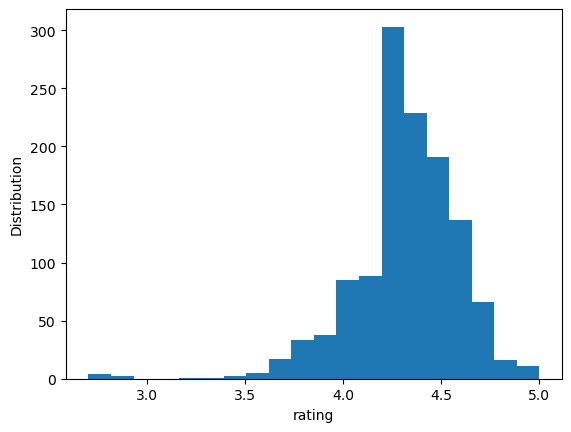

Q1 (33th Percentile): 4.2
Q2 (67th Percentile): 4.5
Two values that divide the rating into three equal parts: 4.2 4.5


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 打印 rating 列的统计描述信息
print(data['rating'].describe())

# 绘制 rating 列的直方图
plt.hist(data['rating'], bins=20)
plt.xlabel('rating')
plt.ylabel('Distribution')
plt.show()

# 计算三等分点
q1 = np.percentile(data['rating'], 33)
q2 = np.percentile(data['rating'], 67)

# 打印三等分点
print("Q1 (33th Percentile):", q1)
print("Q2 (67th Percentile):", q2)

# 找到能把所有rating分为三部分的两个值
r1 = data['rating'][data['rating'] <= q1].max()
r2 = data['rating'][(data['rating'] > q1) & (data['rating'] <= q2)].max()

# 打印结果
print("Two values that divide the rating into three equal parts:", r1, r2)



In [4]:
def rating_to_rate(rating):
    if rating <= 4.2:
        return 0
    elif rating <= 4.5:
        return 1
    else:
        return 2
    
data['rate'] = data['rating'].apply(rating_to_rate)
data.head(5)



,cuisine_count,promo,rating,delivery_cost,delivery_time,rate
627,2,1,5.0,3.3,38.0,2
1099,4,1,4.9,20.8,35.0,2
664,4,1,4.9,17.7,33.0,2
314,5,1,4.9,8.3,46.0,2
52,4,-1,4.9,12.8,64.0,2


In [5]:
len(data)

1229

In [6]:
data.head(1)

,cuisine_count,promo,rating,delivery_cost,delivery_time,rate
627,2,1,5.0,3.3,38.0,2


In [7]:
columns_to_normalize = ['cuisine_count', 'promo','delivery_cost','delivery_time']
data_to_normalize = data[columns_to_normalize]

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data_to_normalize)

data[columns_to_normalize] = normalized_data

In [8]:
data.head(1)

,cuisine_count,promo,rating,delivery_cost,delivery_time,rate
627,0.25,1.0,5.0,0.056769,0.175573,2


In [9]:
from sklearn.model_selection import train_test_split

train_ratio = 0.7  
test_ratio = 0.2 
val_ratio = 0.1    

# 划分训练集和测试集，并保持 rate=1、2、3 的数据平衡
train_data, test_data = train_test_split(data, test_size=test_ratio, random_state=42, stratify=data['rate'])
# 在训练集中再次划分验证集，并保持 rate=1、2、3 的数据平衡
train_data, val_data = train_test_split(train_data, test_size=val_ratio/(train_ratio), random_state=42, stratify=train_data['rate'])


In [10]:
train_data.head(5)

,cuisine_count,promo,rating,delivery_cost,delivery_time,rate
429,1.0,1.0,4.5,0.087336,0.236641,1
992,0.5,1.0,4.4,0.113537,0.053435,1
589,1.0,1.0,4.0,0.109170,0.221374,0
605,0.5,1.0,4.4,0.414847,0.068702,1
990,0.5,1.0,4.5,0.056769,0.099237,1


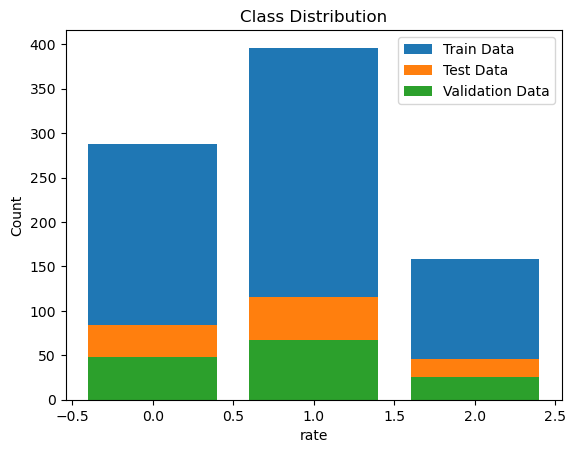

In [11]:
import matplotlib.pyplot as plt

# 计算 train_data 中每个类别的样本数量
train_data_counts = train_data['rate'].value_counts()

# 计算 test_data 中每个类别的样本数量
test_data_counts = test_data['rate'].value_counts()

# 计算 val_data 中每个类别的样本数量
val_data_counts = val_data['rate'].value_counts()

# 创建柱状图
plt.bar(train_data_counts.index, train_data_counts.values, label='Train Data')
plt.bar(test_data_counts.index, test_data_counts.values, label='Test Data')
plt.bar(val_data_counts.index, val_data_counts.values, label='Validation Data')

# 设置图表标题和标签
plt.title('Class Distribution')
plt.xlabel('rate')
plt.ylabel('Count')

# 添加图例
plt.legend()

# 显示图表
plt.show()

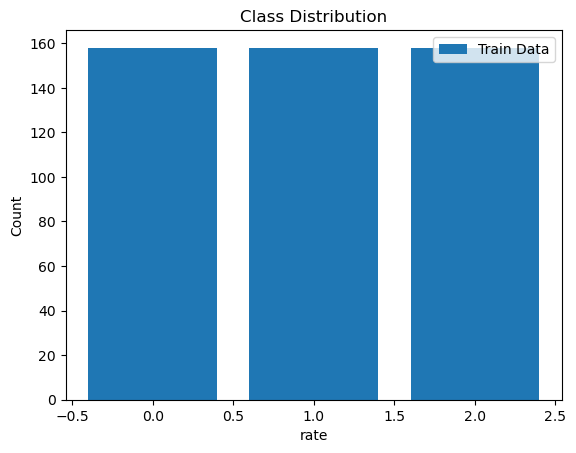

In [12]:
# 计算训练集中各类别的样本数量
train_data_counts = train_data['rate'].value_counts()

# 获取数量最少的类别的样本数量
min_count = train_data_counts.min()

# 对数量较多的类别进行下采样，使其与数量较少的类别的样本数量相当
train_data_balanced = pd.concat([group.sample(n=min_count, replace=False, random_state=42)
                                 for _, group in train_data.groupby('rate')])

# 重新计算 train_data_balanced 中每个类别的样本数量
train_data_balanced_counts = train_data_balanced['rate'].value_counts()

# 创建柱状图
plt.bar(train_data_balanced_counts.index, train_data_balanced_counts.values, label='Train Data')

# 设置图表标题和标签
plt.title('Class Distribution')
plt.xlabel('rate')
plt.ylabel('Count')

# 添加图例
plt.legend()

# 显示图表
plt.show()


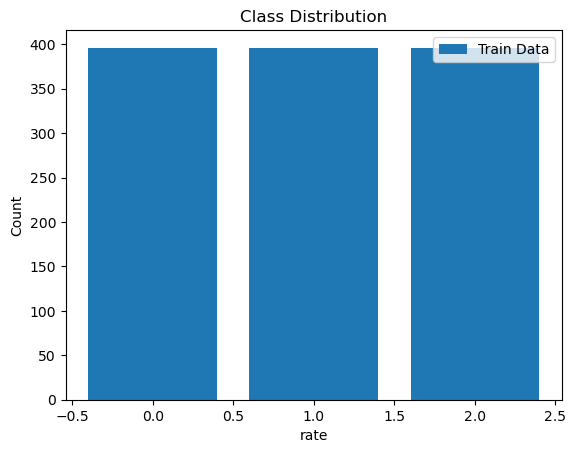

In [13]:
from sklearn.utils import resample

# 计算训练集中各类别的样本数量
train_data_counts = train_data['rate'].value_counts()

# 获取数量最多的类别的样本数量
max_count = train_data_counts.max()

# 对数量较少的类别进行过采样，使其与数量较多的类别的样本数量相当
train_data_balanced = pd.concat([resample(group, n_samples=max_count, replace=True, random_state=42)
                                 for _, group in train_data.groupby('rate')])

# 重新计算 train_data_balanced 中每个类别的样本数量
train_data_balanced_counts = train_data_balanced['rate'].value_counts()

# 创建柱状图
plt.bar(train_data_balanced_counts.index, train_data_balanced_counts.values, label='Train Data')

# 设置图表标题和标签
plt.title('Class Distribution')
plt.xlabel('rate')
plt.ylabel('Count')

# 添加图例
plt.legend()

# 显示图表
plt.show()


count    1229.000000
mean        0.652360
std         0.282365
min         0.000000
25%         0.500000
50%         0.750000
75%         1.000000
max         1.000000
Name: cuisine_count, dtype: float64


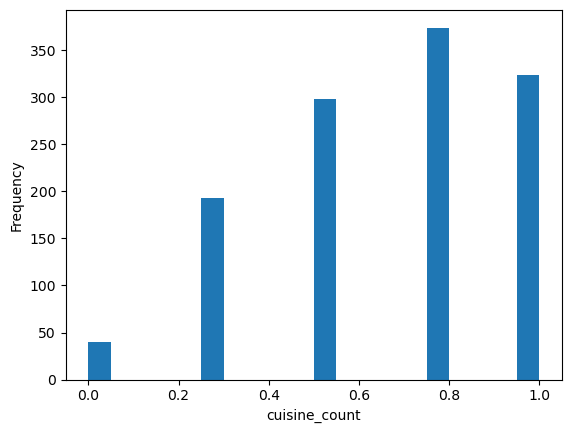

In [14]:
print(data['cuisine_count'].describe())
plt.hist(data['cuisine_count'], bins=20)
plt.xlabel('cuisine_count')
plt.ylabel('Frequency')
plt.show()

count    1229.000000
mean        0.844589
std         0.362443
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: promo, dtype: float64


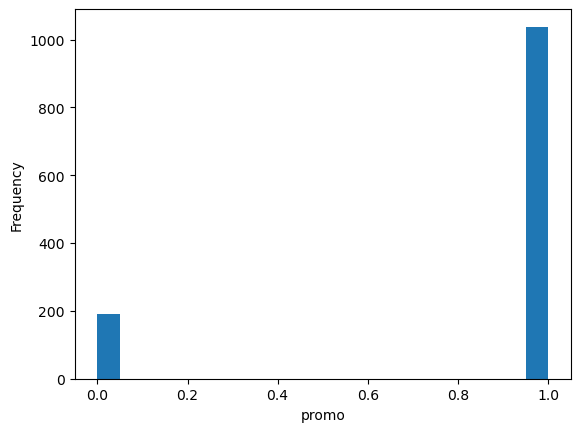

In [15]:
print(data['promo'].describe())
plt.hist(data['promo'], bins=20)
plt.xlabel('promo')
plt.ylabel('Frequency')
plt.show()

count    1229.000000
mean        0.845403
std         0.710912
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: rate, dtype: float64


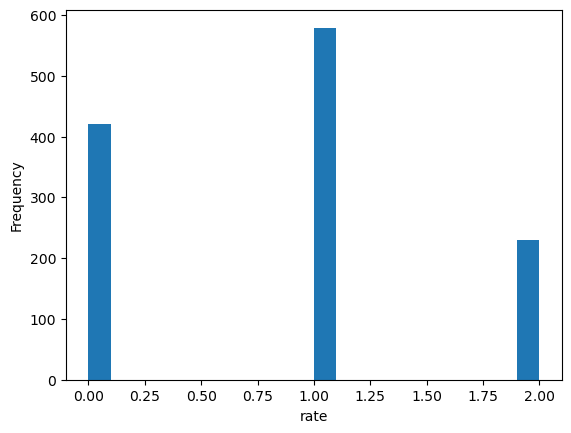

In [16]:
print(data['rate'].describe())
plt.hist(data['rate'], bins=20)
plt.xlabel('rate')
plt.ylabel('Frequency')
plt.show()

### LinearRegression

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

X = train_data[['cuisine_count', 'promo','delivery_cost']]
y = train_data['rate']
X_test = test_data[['cuisine_count', 'promo','delivery_cost']]
y_test = test_data['rate']
X_val = val_data[['cuisine_count', 'promo','delivery_cost']]
y_val = val_data['rate']

scaler = StandardScaler()
X= scaler.fit_transform(X)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

param_grid = {'fit_intercept': [True, False], 'positive': [True, False], 'n_jobs': [-1, 1]}

model = LinearRegression()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X, y)

y_pred = grid_search.predict(X_test)
y_pred = y_pred.round().astype(int)
mse = mean_squared_error(y_test, y_pred)

y_val_pred = grid_search.predict(X_val)
y_val_pred = y_val_pred.round().astype(int)
mse_val = mean_squared_error(y_val, y_val_pred)

accuracy_1 = accuracy_score(y_test, y_pred)
accuracy_2 = accuracy_score(y_val, y_val_pred)

best_model = grid_search.best_estimator_
coefficients = best_model.coef_
intercept = best_model.intercept_

print("Testing accuracy:", accuracy_1)
print("Validation accuracy:", accuracy_2)
print("测试集MSE: ", mse)
print("验证集MSE: ", mse_val)
print("Coefficients:", coefficients)
print("Intercept:", intercept)

Testing accuracy: 0.4715447154471545
Validation accuracy: 0.475177304964539
测试集MSE:  0.5284552845528455
验证集MSE:  0.524822695035461
Coefficients: [-0.10007513  0.04074889  0.07862706]
Intercept: 0.8456057007125891


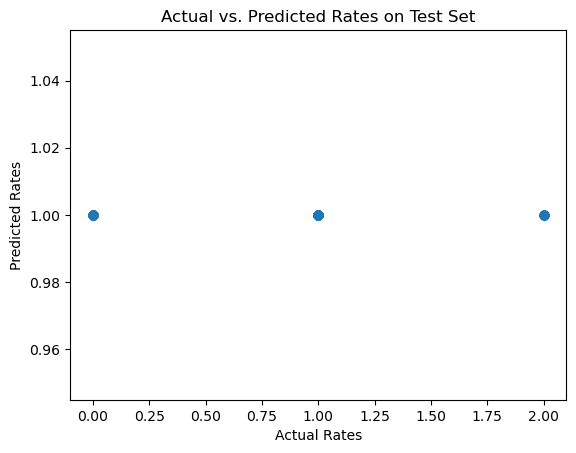

In [18]:
import matplotlib.pyplot as plt

# 绘制测试集预测结果和实际结果的散点图
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Rates')
plt.ylabel('Predicted Rates')
plt.title('Actual vs. Predicted Rates on Test Set')
plt.show()

### SVM

In [29]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

X = train_data[['cuisine_count', 'promo','delivery_cost']]
y = train_data['rate']
X_test = test_data[['cuisine_count', 'promo','delivery_cost']]
y_test = test_data['rate']
X_val = val_data[['cuisine_count', 'promo','delivery_cost']]
y_val = val_data['rate']

scaler = StandardScaler()
X= scaler.fit_transform(X)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

#param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto']}

#model = SVC()
model = SVC(C=10, kernel='rbf', gamma='auto')

#grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
model.fit(X, y)

y_pred = model.predict(X_test)
accuracy_1 = accuracy_score(y_test, y_pred)

y_val_pred = model.predict(X_val)
accuracy_2 = accuracy_score(y_val, y_val_pred)

print("Testing accuracy:", accuracy_1)
print("Validation accuracy:", accuracy_2)

from sklearn.metrics import accuracy_score, mean_squared_error

# 计算测试集的MSE
mse_1 = mean_squared_error(y_test, y_pred)
print("Testing MSE:", mse_1)

# 计算验证集的MSE
mse_2 = mean_squared_error(y_val, y_val_pred)
print("Validation MSE:", mse_2)


Testing accuracy: 0.491869918699187
Validation accuracy: 0.46808510638297873
Testing MSE: 0.7154471544715447
Validation MSE: 0.8085106382978723


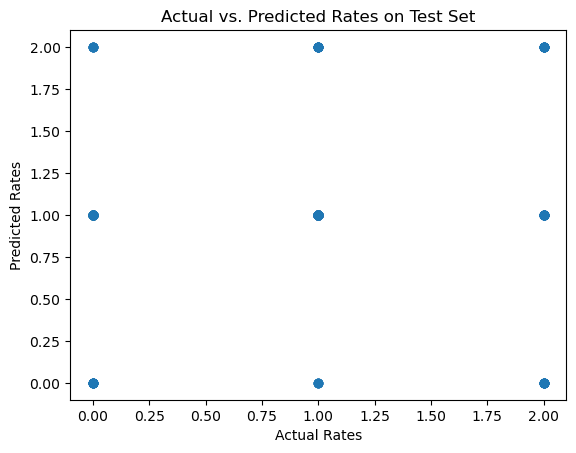

In [182]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Rates')
plt.ylabel('Predicted Rates')
plt.title('Actual vs. Predicted Rates on Test Set')
plt.show()

### DecisionTree

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

X = train_data[['cuisine_count', 'promo','delivery_cost']]
y = train_data['rate']
X_test = test_data[['cuisine_count', 'promo','delivery_cost']]
y_test = test_data['rate']
X_val = val_data[['cuisine_count', 'promo','delivery_cost']]
y_val = val_data['rate']

scaler = StandardScaler()
X= scaler.fit_transform(X)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

#param_grid = {'max_depth': [3, 5, 7, 10], 'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 5, 10]}

model = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=10)

#grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
model.fit(X, y)

y_pred = model.predict(X_test)
accuracy_1 = accuracy_score(y_test, y_pred)

y_val_pred = model.predict(X_val)
accuracy_2 = accuracy_score(y_val, y_val_pred)

print("Testing accuracy:", accuracy_1)
print("Validation accuracy:", accuracy_2)

from sklearn.metrics import accuracy_score, mean_squared_error

# 计算测试集的MSE
mse_1 = mean_squared_error(y_test, y_pred)
print("Testing MSE:", mse_1)

# 计算验证集的MSE
mse_2 = mean_squared_error(y_val, y_val_pred)
print("Validation MSE:", mse_2)


Testing accuracy: 0.43089430894308944
Validation accuracy: 0.48936170212765956
Testing MSE: 0.9227642276422764
Validation MSE: 0.851063829787234


### RandomForest

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

X = train_data[['cuisine_count', 'promo','delivery_cost']]
y = train_data['rate']
X_test = test_data[['cuisine_count', 'promo','delivery_cost']]
y_test = test_data['rate']
X_val = val_data[['cuisine_count', 'promo','delivery_cost']]
y_val = val_data['rate']

scaler = StandardScaler()
X= scaler.fit_transform(X)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

model = RandomForestClassifier(n_estimators=1000, max_depth=10, min_samples_split=200)
model.fit(X, y)

y_pred = model.predict(X_test)
accuracy_1 = accuracy_score(y_test, y_pred)

y_val_pred = model.predict(X_val)
accuracy_2 = accuracy_score(y_val, y_val_pred)

print("Testing accuracy:", accuracy_1)
print("Validation accuracy:", accuracy_2)

from sklearn.metrics import accuracy_score, mean_squared_error

# 计算测试集的MSE
mse_1 = mean_squared_error(y_test, y_pred)
print("Testing MSE:", mse_1)

# 计算验证集的MSE
mse_2 = mean_squared_error(y_val, y_val_pred)
print("Validation MSE:", mse_2)



Testing accuracy: 0.4796747967479675
Validation accuracy: 0.49645390070921985
Testing MSE: 0.5691056910569106
Validation MSE: 0.5460992907801419
